In [1]:
import pandas as pd
import numpy as np
import ast
import datetime

import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [2]:
credentials = ast.literal_eval(open(r"C:\Users\pablo\OneDrive - unizar.es\Python Investigación\credentials.txt", "r").read())
sql_engine = create_engine(credentials['sqlalchemy'][0]+ 'market_index')
index_details = pd.read_sql('index_details',sql_engine)
index_details = index_details.loc[~index_details['index_ticker'].isin(['LFT4G100','LFT4U100'])]

In [10]:
df_results = pd.DataFrame()
for group in pd.unique(index_details.family_1):
    
    conventional = pd.unique(index_details.loc[(index_details['family_1']==group)&(index_details['type']=='Conventional'), 
                                 'index_ticker'])
    sustainability = pd.unique(index_details.loc[(index_details['family_1']==group)&(index_details['type']=='Sustainability'), 
                                 'index_ticker']) # sometimes there more than one sustainability

    query = sql_query(conventional[0], (2008,1,1), (2019,12,31) )
    df_conv = pd.read_sql(query, sql_engine)
    df_share=pd.DataFrame(index= pd.unique(df_conv['monthly_date']))

    for sust_ticker in sustainability:

        query = sql_query(sust_ticker, (2008,1,1), (2019,12,31))
        df_sust = pd.read_sql(query, sql_engine)

        df = active_share (df_conv,df_sust, 'monthly_date', 'datastream_id', 'company_weight')
        df_share = df_share.merge(df, how='inner', left_index=True, right_index=True)
        df_share.rename(columns = {'active_share':sust_ticker},inplace=True)

        df_sust_eqw = equally_weighted(df_sust,'monthly_date', 'datastream_id', 'company_weight')
        df = active_share (df_conv,df_sust_eqw, 'monthly_date', 'datastream_id', 'company_weight')
        df_share = df_share.merge(df, how='inner', left_index=True, right_index=True)
        df_share.rename(columns = {'active_share':sust_ticker +'_ew'},inplace=True)

    df_share['family']=group
    df_results=pd.concat([df_results, df_share], axis=0)

df_results.index.name = 'monthly_date'
df_results = df_results.pivot_table(index='monthly_date',columns='family',
                                 aggfunc='first').reorder_levels([1,0],axis=1).sort_index(axis=1,level=0)


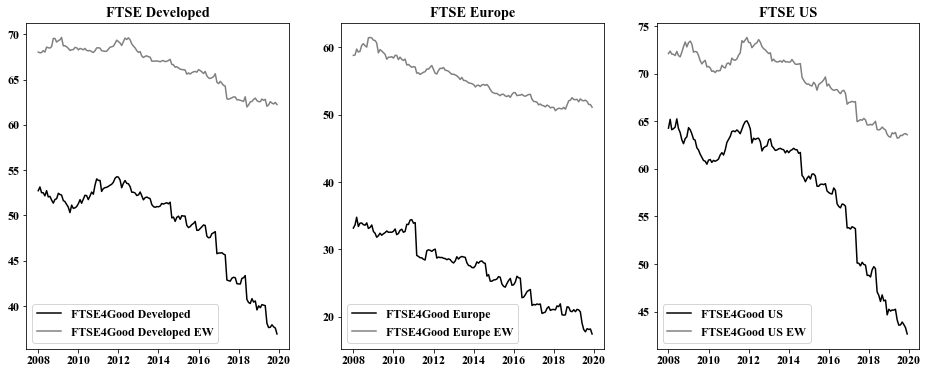

In [11]:
colors = ('black', 'grey', 'grey')
styles = ('-','-', '-', '--')
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size']=12

# Change the ticker to the name of the provider
for provider_name, index_ticker in zip(index_details['provider_name'].to_list(), index_details['index_ticker'].to_list()):
    df_results.rename({index_ticker : provider_name}, axis=1, level=1, inplace=True)
    df_results.rename({index_ticker+'_ew' : provider_name + " EW"}, axis=1, level=1, inplace=True)


fig, axes = plt.subplots(ncols=3, figsize=(16,6))

for ax, group in zip(axes, pd.unique(index_details.family_1)):
    df_plot = df_results.loc[:,(group)]
    for index, color, style in zip(df_plot.columns, colors, styles):
        ax.plot(df_plot[index], label=index, c= color, linestyle= style )
    ax.set_title(group)
    ax.legend()

fig.savefig(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Figure 1 Active Share.pdf", dpi=1200, 
          orientation='portrait')
fig.savefig(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Figure 1 Active Share.png", dpi=1200, 
          orientation='portrait')
df_results.to_excel(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\1. Check and TS\TS Active Share.xlsx")


In [10]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

css_style="""<style>
    table {
      border-collapse: collapse;
      
    }

    th, td {
      text-align: center;

      padding: 8px;
    }

    tr:nth-child(even) {background-color: rgb(242, 242, 242);}

    </style>
    """


In [45]:
df_h1 = pd.DataFrame()
X=( (df_results.index - df_results.index.min() )/ np.timedelta64(1,'Y') ).to_list()
X=sm.add_constant(X)
for group in pd.unique(index_details['family_1']):
    # Dependent and independet
    df = df_results.loc[:, (group)].unstack().to_frame()
    df.columns = ['active_share']
    df.index.names=['method', 'time']
    df.reset_index(inplace=True)
    df['time']=( (df.time - df.time.min() )/ np.timedelta64(1,'Y') )
    # Model
    model = smf.ols(formula='active_share ~ method + time + time*method', data=df)
    results = model.fit() 
    df_metrics = model_metrics(results,['Intercept', 'EW', 'Time', 'Time*EW'])
    df_metrics.index=[group]
    # Concat Results
    df_h1=pd.concat([df_h1, df_metrics], axis=0)
    

df_h1.index.name='Index'
df_h1.reset_index(inplace=True)
df_h1['Dependent Variable']= 'Sustainability Share'
df_h1.set_index(['Dependent Variable', 'Index'],inplace=True )


Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Table 3 H1.html","w")
Html_file.write(css_style + df_h1.to_html().replace("\\n", "<br>"))
Html_file.close()

In [36]:
df = index_details.loc[:, ['provider_name', 'family_1', 'type', 'market', 'refinitiv_name', 'index_ticker']]
df.set_index(['family_1'], inplace=True, append=True)
df = df.reorder_levels([1,0])
df = df.sort_index(level=0)
df = df.to_html()
for col, col_c in  zip (['provider_name', 'family_1', 'type', 'market', 'refinitiv_name', 'index_ticker'],
                        ['Provider Name', 'Family', 'Type', 'Market', 'Refinitiv Name', 'Index Ticker']):
    df = df.replace(col, col_c)

Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\Table 1 Indices Description.html","w")
Html_file.write(css_style + df)
Html_file.close()

,provider_name,type,market,refinitiv_name,index_ticker
family_1,,,,,
FTSE Developed,FTSE4Good Developed,Sustainability,Global,FTSE4GOOD GLOBAL (US$),LFT4GBGL
FTSE Developed,FTSE Developed,Conventional,Global,FTSE AW ALL-WORLD DEVELOPED,LAWDVLP
FTSE Europe,FTSE4Good Europe,Sustainability,Europe,FTSE4GOOD EUROPE (E),LFT4GBEU
FTSE Europe,FTSE Developed Europe,Conventional,Europe,FTSE AW DEVELOPED EUROPE,LAWDVER
FTSE US,FTSE4Good US,Sustainability,United States,FTSE4GOOD US (US$),LFT4GBUS
FTSE US,FTSE USA,Conventional,United States,FTSE W UNITED STATES,LWIUSAM


In [5]:
def active_share (holding_1, holding_2, date_col, company_col, weight_col):
    # Null values wil be considered as one active --> before groupby we use fillna
    holding_1[company_col].fillna(value="null", inplace=True)
    holding_2[company_col].fillna(value="null", inplace=True)
    dates = np.intersect1d( pd.unique(holding_1[date_col]), pd.unique(holding_2[date_col]))
    df_active_share = pd.DataFrame(index=dates, columns =['active_share'])
    for date in dates:
        # We group weight by company id
        df_1 = holding_1.loc[holding_1[date_col]== date,:].groupby([company_col])[weight_col].sum()
        df_1 = df_1.to_frame().reset_index()
        df_2 = holding_2.loc[holding_2[date_col]== date,:].groupby([company_col])[weight_col].sum()
        df_2 = df_2.to_frame().reset_index()
        # we transform to frame and we merge
        df = df_1.merge(df_2,  how='outer', on=company_col)
        active_share = np.sum( np.abs(df[weight_col+'_x'].fillna(0)-df[weight_col+'_y'].fillna(0)) )/2
        df_active_share.at[date,'active_share']=active_share
        
    return df_active_share

def equally_weighted (holding, date_col, company_col, weight_col):
    # We group the constituetns to avoid duplicates and null values
    holding[company_col].fillna(value="null", inplace=True)
    holding = holding.groupby([date_col, company_col])[weight_col].sum().to_frame().reset_index()
    df = holding.groupby([date_col])[company_col].count().to_frame() # Nº Constituents
    df[weight_col] = 100/df[company_col] # equally weight
    holding = holding.loc[:,[date_col, company_col]].merge(df[weight_col],on=date_col, how='inner')
    return holding

def sql_query(index_ticker, start_date, end_date):
    sql_query = """
    SELECT datastream_id, monthly_date, company_weight
    FROM index_constituents
    WHERE (index_ticker = '%s') AND (monthly_date BETWEEN '%s' AND '%s')
    ORDER BY monthly_date
    """ % (index_ticker, datetime.date(*(start_date)), datetime.date(*(end_date)) )
    return sql_query

In [4]:
def model_metrics(model_results, model_variables):
    df = pd.DataFrame(index=model_variables, 
                      data= {'Coeficients':model_results.params.round(2).to_list(),
                             'Std.Err.': model_results.bse.round(3).to_list(),
                             'P-value':model_results.pvalues.to_list()})
    df = (df['Coeficients'].map('{:.2f}'.format).astype(str) + df['P-value'].apply(significance) +
          df["Std.Err."].map('{:.3f}'.format).astype(str).apply(lambda x:  "("+ x + ")") ).to_frame()
    df = df.T
    df['#'] = model_results.nobs
    df['R-squared'] = model_results.rsquared.round(2)
    return df
    
def significance(p_val):
    if p_val <=0.05 and p_val > 0.01 :
        significance = "*"
    elif p_val <=0.01 and p_val > 0.001:
        significance = "**"
    elif p_val <=0.001 :
        significance = "**"
    else:
        significance=""
    significance += "\n"
    return significance

In [ ]:
df_h1b = pd.DataFrame()
X=( (df_results.index - df_results.index.min() )/ np.timedelta64(1,'Y') ).to_list()
X=sm.add_constant(X)
for group in pd.unique(index_details['family_1']):
    Y=  (df_results.loc[:, group].iloc[:,1]-df_results.loc[:, group].iloc[:,0]).to_list()
    model = sm.OLS(Y, X)
    results = model.fit()
    df_metrics = model_metrics(results,['Intercept', 'Time in years'])
    df_metrics.index=[group]
    
    df_h1b=pd.concat([df_h1b, df_metrics], axis=0)
       

df_h1b.index.name='Family'
df_h1b.reset_index(inplace=True)
df_h1b['Dependent Variable']= 'Difference of Sustainability Share'
df_h1b.set_index(['Dependent Variable', 'Family'], inplace=True )

Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\H1B.html","w")
Html_file.write(css_style + df_h1b.to_html().replace("\\n", "<br>"))
Html_file.close()

df_h1c = pd.DataFrame()
for group in pd.unique(index_details['family_1']):
    df = df_results.loc[:, group].mean().round(2).to_frame().T
    df.index.name = 'Family'
    df.index = [group]
    df.columns = ['FTSE4Good', 'FTSE4Good EW']
    wilcoxon_test = wilcoxon(df_results.loc[:, group].iloc[:,0], df_results.loc[:, group].iloc[:,1])
    t_test = ttest_ind(df_results.loc[:, group].iloc[:,0], df_results.loc[:, group].iloc[:,1])
    df['T-Test'] = (t_test[0].round(2).astype(str) + significance(t_test[1]))[:-1]
    df['Wilcoxon'] = (wilcoxon_test[0].round(2).astype(str) + significance(wilcoxon_test[1]))[:-1]
    
    df_h1c=pd.concat([df_h1c, df], axis=0)
       
Html_file= open(r"C:\Users\pablo\OneDrive - unizar.es\Tesis\Artículo 4 Sustainability Share\2. Results\2. Draft\H1C.html","w")
Html_file.write(css_style + df_h1c.to_html().replace("\\n", "<br>"))
Html_file.close()